add image_preprocessing_ver_3.py

In [0]:
import keras
from keras.applications.mobilenetv2 import MobileNetV2
from keras.models import Model
from keras.layers import Activation, GlobalAveragePooling2D, Dropout, Dense, Input


def get_mobilenet(input_size, alpha, weight_decay, dropout):
    input_shape = (input_size, input_size, 3)
    base_model = MobileNetV2(
        include_top=False, weights='imagenet', 
        input_shape=input_shape, alpha=alpha
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    logits = Dense(10, kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    probabilities = Activation('softmax')(logits)
    model = Model(base_model.input, probabilities)
    
    for layer in model.layers[:-2]:
        layer.trainable = False
    
    return model

Using TensorFlow backend.


In [0]:
import numpy as np

import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# use non standard flow_from_directory
from image_preprocessing_ver3 import ImageDataGenerator
# it outputs y_batch that contains logits(no one hot)
# logits came from xception

from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
from keras.applications.mobilenetv2 import MobileNetV2,preprocess_input



import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
data_dir = 'img/'

In [0]:
train_logits = np.load('train_logits_temp1.npy')[()]
val_logits = np.load('val_logits_temp1.npy')[()]

In [0]:
data_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

# note: i'm also passing dicts of logits
train_generator = data_generator.flow_from_directory(
    data_dir + 'train', train_logits,
    target_size=(224, 224),
    batch_size=50
)

val_generator = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(224, 224),
    batch_size=50
)


Found 5000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [0]:
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

In [0]:
from PIL import Image as pil_image
def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])

In [0]:
# get a random batch
pictures, labels_and_logits = train_generator.next()
logits = labels_and_logits

In [0]:
data_format = K.image_data_format()
img = array_to_img(pictures[1],data_format,scale=True)
fname = '{prefix}_{index}_{hash}.{format}'.format(prefix="a",
         index=0,hash=np.random.randint(1e4),format="jpg")
img.save(fname)
fname

'a_0_3274.jpg'

In [0]:
logits[1]

array([9.9999368e-01, 3.3085465e-07, 4.0610024e-07, 1.0596140e-07,
       3.3236572e-07, 4.6808839e-07, 2.3654168e-07, 3.5196638e-07,
       2.7739607e-06, 1.4215507e-06], dtype=float32)

test 1 ->5
array([-3.1431096 , -2.3487477 , -1.8943748 ,  2.6037343 ,  4.023663  ,
        5.818794  , -0.39959738, -1.4278562 , -2.1753347 , -1.8591523 ],
      dtype=float32)
      
 test 2 ->4
 array([-2.6974385 , -2.3446827 , -2.6954975 ,  0.74625957, 11.059016  ,
       -0.957347  ,  2.9704058 , -2.173234  , -1.9789734 , -1.9399166 ],
      dtype=float32)
      
  test3->9
  array([ 2.682344 , -2.8602762,  4.663039 , -3.2968268, -2.1818123,
       -2.8666215, -1.1493819, -3.0989358, -0.8861797,  8.244205 ],
      dtype=float32)



In [0]:
np.sum(logits[1])

1.0000001

In [0]:
softmax(logits[1]/3)

array([0.13424985, 0.09619444, 0.09619444, 0.09619442, 0.09619444,
       0.09619444, 0.09619444, 0.09619444, 0.09619452, 0.09619447],
      dtype=float32)

In [0]:
np.argmax(logits[1])#5

9

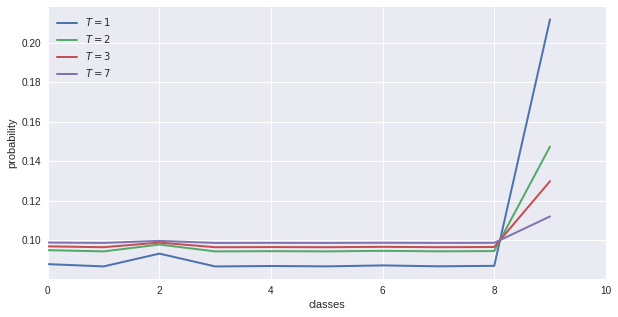

In [0]:
# logits for a random image
v = logits[1]
plt.figure(figsize=(10, 5));
plt.plot(softmax(v), label='$T=1$', linewidth=2);
plt.plot(softmax(v/2), label='$T=2$', linewidth=2);
plt.plot(softmax(v/3), label='$T=3$', linewidth=2);
plt.plot(softmax(v/7), label='$T=7$', linewidth=2);
plt.legend();
plt.xlabel('classes');
plt.ylabel('probability');
plt.xlim([0, 10]);
plt.savefig('5.jpg')

In [0]:
#!cp "5.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/testt_graph3.jpg"
#!cp "a_0_9443.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/test_img3.jpg"

cp: cannot stat 'a_0_9443.jpg': No such file or directory


In [0]:
temperature = 3.0


In [0]:
#!wget https://raw.githubusercontent.com/Ujjwal-9/Knowledge-Distillation/master/squeezenet_weights.hdf5

--2019-02-25 06:45:18--  https://raw.githubusercontent.com/Ujjwal-9/Knowledge-Distillation/master/squeezenet_weights.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3034616 (2.9M) [application/octet-stream]
Saving to: ‘squeezenet_weights.hdf5.1’

squeezenet_weights. 100%[===================>]   2.89M  --.-KB/s    in 0.1s    

2019-02-25 06:45:30 (29.2 MB/s) - ‘squeezenet_weights.hdf5.1’ saved [3034616/3034616]



In [0]:
model = get_mobilenet(224, alpha=0.35, weight_decay=1e-5, dropout=0.1)
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/classification/mobilenet/mobilenet.h5', by_name=True)

# remove softmax
model.layers.pop()

# usual probabilities (change to this if get logits already went thourugh softmax)
logits = model.layers[-1].output
probabilities = Activation('softmax')(logits)

# softed probabilities
#logits_T = Lambda(lambda x: x/temperature)(logits)#temperature
#probabilities_T = Activation('softmax')(logits_T)

#output = concatenate([probabilities, probabilities_T])
model = Model(model.input, probabilities)#output
# now model outputs 512 dimensional vectors

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
#lambda_const = 0.2

model.compile(
    optimizer=optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

In [0]:

model.fit_generator(
    train_generator, 
    steps_per_epoch=5000//50, epochs=30, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=10, min_delta=0.01),
        ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, epsilon=0.007)
    ],
    validation_data=val_generator, 
    validation_steps=3000//50, 
    workers=4
)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/30
100/100 [==============================] - 19s 193ms/step - loss: 0.7292 - acc: 0.7700 - top_k_categorical_accuracy: 0.9682 - val_loss: 1.0539 - val_acc: 0.6347 - val_top_k_categorical_accuracy: 0.9660
Epoch 2/30
100/100 [==============================] - 14s 140ms/step - loss: 0.4046 - acc: 0.8858 - top_k_categorical_accuracy: 0.9960 - val_loss: 1.0576 - val_acc: 0.6533 - val_top_k_categorical_accuracy: 0.9637
Epoch 3/30
100/100 [==============================] - 14s 143ms/step - loss: 0.3534 - acc: 0.9000 - top_k_categorical_accuracy: 0.9978 - val_loss: 0.9361 - val_acc: 0.6953 - val_top_k_categorical_accuracy: 0.9710
Epoch 4/30
100/100 [==============================] - 14s 143ms/step - loss: 0.3224 - acc: 0.9080 - top_k_categorical_accuracy: 0.9980 - val_loss: 0.9409 - val_acc: 0.7010 - val_top_k_categorical_accuracy: 0.9703
Epoch 5/30
100/100 [==============================] - 14s 143ms/step - loss: 0.3141 - acc: 0.9100 - top_k_categorical_accuracy: 0.9978 - val_loss: 1

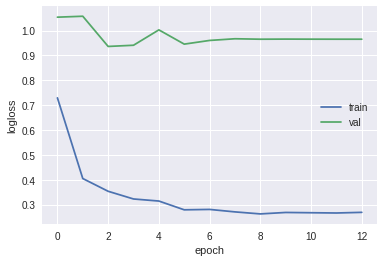

In [0]:
plt.plot(model.history.history['loss'], label='train');
plt.plot(model.history.history['val_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');
plt.savefig('mobilenet_distill_loss.jpg')

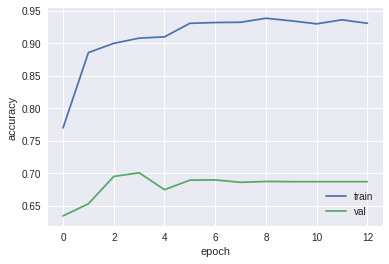

In [0]:
plt.plot(model.history.history['acc'], label='train');
plt.plot(model.history.history['val_acc'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');
plt.savefig('mobilenet_distill_acc.jpg')

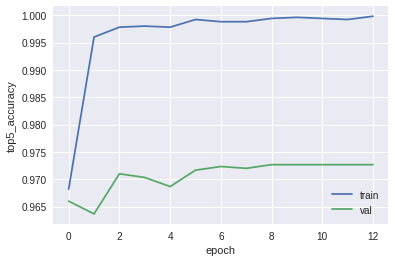

In [0]:
plt.plot(model.history.history['top_k_categorical_accuracy'], label='train');
plt.plot(model.history.history['val_top_k_categorical_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');
plt.savefig('mobilenet_distill_top5_acc.jpg')

In [0]:
val_generator_no_shuffle = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(224, 224),
    batch_size=50, shuffle=False
)

Found 3000 images belonging to 10 classes.


In [0]:
model.evaluate_generator(val_generator_no_shuffle, 80)

[0.9806350735016167, 0.678999999910593, 0.9752500012516976]

In [0]:
model.save("mobilenet_distill.h5")

In [0]:
data_train_generator = keras.preprocessing.image.ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

test_generator = data_train_generator.flow_from_directory(
    data_dir + 'test', shuffle=False,
    target_size=(224, 224),
    batch_size=50
)

Found 5000 images belonging to 10 classes.


In [0]:
from keras.models import Model,load_model
#vmodel = SqueezeNet(weight_decay=1e-4, image_size=299 )#1e-4
vmodel = load_model('/content/gdrive/My Drive/Colab Notebooks/classification/mobilenet/mobilenet.h5')
vmodel.evaluate_generator(test_generator, 80)

[1.4247967766597867, 0.5422499997541308, 0.9507499963045121]

In [0]:
model.evaluate_generator(test_generator, 80)

[0.9691366954473779, 0.675500001758337, 0.9720000021159649]

In [0]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1,steps=STEP_SIZE_TEST)

100/100 [==============================] - 16s 156ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
#lbl = [ "airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey" , "ship", "truck" ]  
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
import pandas as pd 
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("mobilenet_distill_results.csv",index=False)

In [0]:
!cp "mobilenet_distill.h5" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_mobilenet/mobilenet.h5"
!cp "mobilenet_distill_results.csv" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_mobilenet/mobilenet_results.csv"
!cp "mobilenet_distill_acc.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_mobilenet/mobilenet_acc.jpg"
!cp "mobilenet_distill_loss.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_mobilenet/mobilenet_loss.jpg"
!cp "mobilenet_distill_top5_acc.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_mobilenet/mobilenet_top5_acc.jpg"